#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요함. 그래서 **선택과 집중** 필요.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구함.   
    * random forest 알고리즘 사용을 권장.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나눔.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [4]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10, 20 if topn=='all' else topn/2))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [5]:
original_data = pd.read_csv(path+'data01_train.csv')
data = original_data.copy()

In [6]:
data.drop(columns='subject', inplace=True)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB
None


In [8]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [9]:
data.corr(numeric_only=True)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
tBodyAcc-mean()-X,1.000000,0.203297,-0.266383,0.012067,-0.018489,-0.040405,0.018367,-0.019752,-0.043303,0.048725,...,0.023137,-0.012101,-0.011490,-0.567455,0.019251,0.034065,0.030968,-0.027010,0.028177,0.019025
tBodyAcc-mean()-Y,0.203297,1.000000,-0.145709,-0.049467,-0.052489,-0.058499,-0.048703,-0.053018,-0.058559,-0.038544,...,-0.015872,-0.003101,-0.003467,0.076995,-0.013001,0.019670,0.074955,0.000039,0.002376,-0.022329
tBodyAcc-mean()-Z,-0.266383,-0.145709,1.000000,-0.024839,-0.017613,-0.016924,-0.023323,-0.015794,-0.012575,-0.040397,...,-0.017359,0.018155,0.018234,0.056806,-0.036749,-0.054069,-0.035593,0.007045,-0.017900,-0.019169
tBodyAcc-std()-X,0.012067,-0.049467,-0.024839,1.000000,0.927809,0.851841,0.998656,0.921154,0.846308,0.981190,...,-0.070634,0.151555,0.116425,-0.043069,-0.032145,0.016542,-0.024749,-0.373500,0.470834,0.392843
tBodyAcc-std()-Y,-0.018489,-0.052489,-0.017613,0.927809,1.000000,0.893995,0.923386,0.997320,0.892843,0.916853,...,-0.107573,0.209119,0.177232,-0.027671,-0.022181,-0.012927,-0.015237,-0.380258,0.521249,0.429141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",0.034065,0.019670,-0.054069,0.016542,-0.012927,-0.016674,0.016846,-0.015394,-0.021836,0.021599,...,-0.027836,0.029841,0.019651,-0.003279,0.000576,1.000000,-0.113677,-0.001992,-0.013863,-0.021702
"angle(tBodyGyroJerkMean,gravityMean)",0.030968,0.074955,-0.035593,-0.024749,-0.015237,-0.004077,-0.025205,-0.013152,-0.004784,-0.028239,...,-0.004927,-0.018015,-0.015179,-0.027075,0.029856,-0.113677,1.000000,0.012598,0.005132,0.001242
"angle(X,gravityMean)",-0.027010,0.000039,0.007045,-0.373500,-0.380258,-0.346237,-0.370024,-0.376665,-0.348279,-0.385300,...,0.077532,-0.088810,-0.080113,0.012382,0.020700,-0.001992,0.012598,1.000000,-0.783107,-0.639201
"angle(Y,gravityMean)",0.028177,0.002376,-0.017900,0.470834,0.521249,0.473572,0.466287,0.522401,0.474880,0.478832,...,-0.097644,0.092383,0.080726,-0.000955,-0.013508,-0.013863,0.005132,-0.783107,1.000000,0.590883


In [10]:
print(data.head(10))
print(data.tail(10))

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288508          -0.009196          -0.103362         -0.988986   
1           0.265757          -0.016576          -0.098163         -0.989551   
2           0.278709          -0.014511          -0.108717         -0.997720   
3           0.289795          -0.035536          -0.150354         -0.231727   
4           0.394807           0.034098           0.091229          0.088489   
5           0.330708           0.007561          -0.061371         -0.215760   
6           0.121465          -0.031902          -0.005196         -0.152198   
7           0.272026          -0.001329          -0.125491         -0.992068   
8           0.284338           0.021956          -0.006925         -0.980153   
9           0.275352           0.011248          -0.048331         -0.973058   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.962797         -0.967422     

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [11]:
target = 'Activity'

In [12]:
data[target].value_counts().sort_values()

,count
Activity,
WALKING_DOWNSTAIRS,791
WALKING_UPSTAIRS,858
WALKING,998
SITTING,1032
STANDING,1087
LAYING,1115


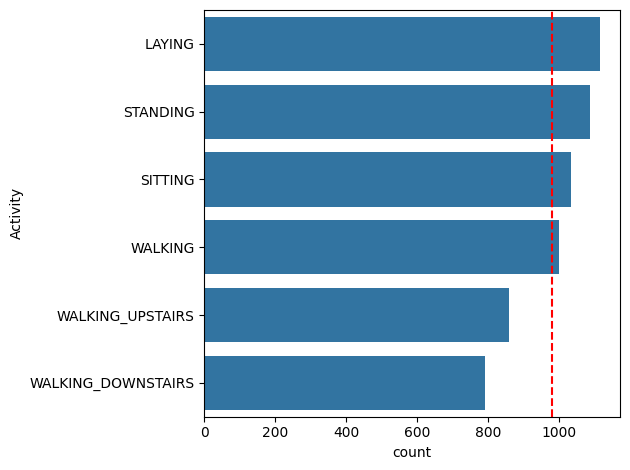

In [13]:
sns.countplot(y=data[target], order=data[target].value_counts().index)
plt.axvline(data[target].value_counts().mean(), color='red', linestyle='--')
plt.tight_layout()
plt.show()

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요.  **선택과 집중**.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구함.   
    * random forest 알고리즘 사용을 권장.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있음.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있음.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [14]:
x = data.drop(columns=target)
y = data.loc[:, target]
x_train, x_val, y_train, y_val = train_test_split (x, y, test_size=0.3, random_state=20)

#### 2) 모델링

In [15]:
# params = {'max_depth': list(range(5, 11))}
# model = GridSearchCV(RandomForestClassifier(), params, cv=5)
# model.fit(x_train, y_train)

model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [16]:
y_pred = model.predict(x_val)

# print("Best parameters found: ", model.best_params_)
# print("Best cross-validation score: ", model.best_score_)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[312   0   0   0   0   0]
 [  0 306  17   0   0   0]
 [  0  12 309   0   0   0]
 [  0   0   0 289   2   1]
 [  0   0   0   1 253   0]
 [  0   0   0   0   4 259]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       312
           SITTING       0.96      0.95      0.95       323
          STANDING       0.95      0.96      0.96       321
           WALKING       1.00      0.99      0.99       292
WALKING_DOWNSTAIRS       0.98      1.00      0.99       254
  WALKING_UPSTAIRS       1.00      0.98      0.99       263

          accuracy                           0.98      1765
         macro avg       0.98      0.98      0.98      1765
      weighted avg       0.98      0.98      0.98      1765



#### 3) 변수 중요도 추출

In [17]:
# fy = model.best_estimator_.feature_names_in_
# fx = model.best_estimator_.feature_importances_

fy = model.feature_names_in_
fx = model.feature_importances_

sort_dict = {}
for i in range(len(fy)):
  sort_dict[fy[i]] = fx[i]

sort_dict = sorted(sort_dict.items(), key=lambda x: x[1])

asc_list = sort_dict[:5]
desc_list = sort_dict[-5:]

# plt.barh(y=list(x_train), width=model.best_estimator_.feature_importances_)
# plt.show()

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [18]:
# 상위 하위 수치 확인
for temp in asc_list:
  print(f'{temp[0]} : {temp[1]:.6f}')

print()

for temp in desc_list:
  print(f'{temp[0]} : {temp[1]:.6f}')

fBodyAcc-bandsEnergy()-49,56.1 : 0.000066
fBodyAcc-bandsEnergy()-33,48 : 0.000069
fBodyAcc-bandsEnergy()-49,64.1 : 0.000078
tBodyGyroMag-iqr() : 0.000085
fBodyAcc-iqr()-Y : 0.000099

angle(X,gravityMean) : 0.023646
tGravityAcc-max()-Y : 0.024343
tGravityAcc-max()-X : 0.024998
tGravityAcc-min()-X : 0.026205
tGravityAcc-mean()-X : 0.031704


                            feature_cate       max
4            angle(tBodyAccMean,gravity)  0.000111
3   angle(tBodyAccJerkMean),gravityMean)  0.000226
5   angle(tBodyGyroJerkMean,gravityMean)  0.000372
6       angle(tBodyGyroMean,gravityMean)  0.000663
21                          tBodyGyroMag  0.000702
20                      tBodyGyroJerkMag  0.000956
12                      fBodyBodyGyroMag  0.001436
11                  fBodyBodyGyroJerkMag  0.001558
10                   fBodyBodyAccJerkMag  0.002175
19                         tBodyGyroJerk  0.003015
13                             fBodyGyro  0.004105
18                             tBodyGyro  0.004507
2                   angle(Z,gravityMean)  0.007281
23                        tGravityAccMag  0.008162
7                               fBodyAcc  0.008264
14                              tBodyAcc  0.008584
16                       tBodyAccJerkMag  0.008705
9                            fBodyAccMag  0.010009
8                           fBo

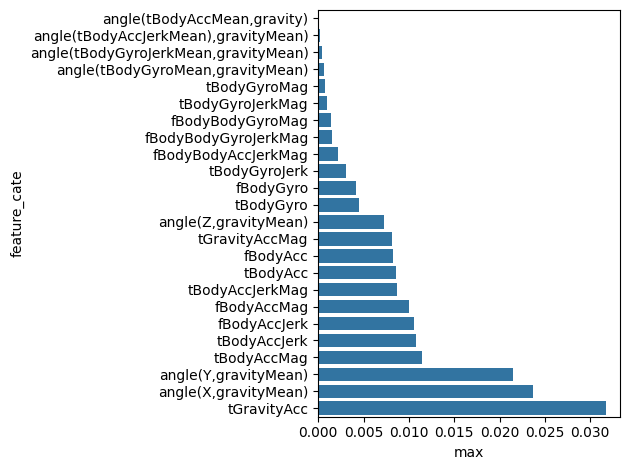

In [19]:
# 변수 중요도를 센서별로 확인
result = plot_feature_importance(model.feature_importances_, model.feature_names_in_, result_only=True, topn='all')

result['feature_cate'] = result['feature_name'].apply(lambda x : x.split('-')[0])

result = result.groupby(by='feature_cate')['feature_importance'].agg(['max'])
result = result.reset_index()
result = result.sort_values(by='max')

print(result)

sns.barplot(y=result['feature_cate'], x=result['max'])
# plt.axvline(data[target].value_counts().mean(), color='red', linestyle='--')
plt.tight_layout()
plt.show()

#### 2) 상위 5개 변수에 대한 분석

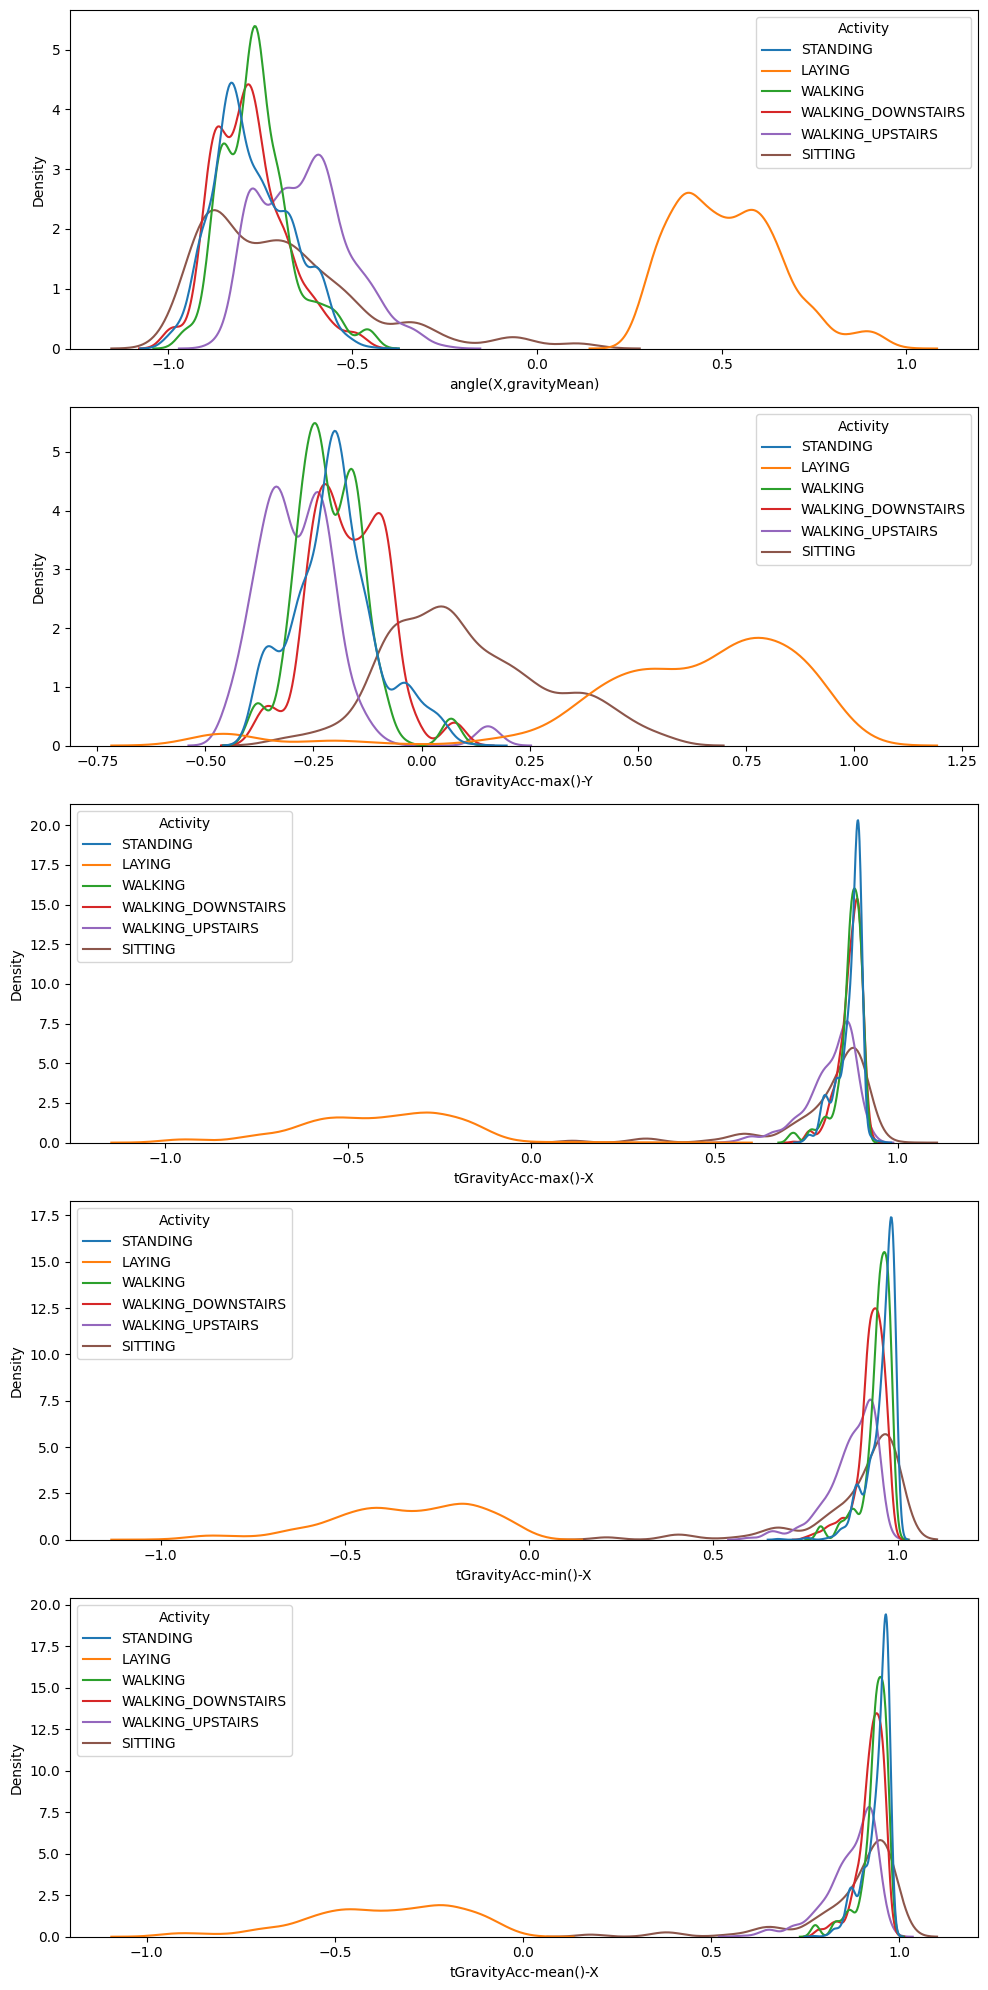

In [20]:
plt.figure(figsize=(10, len(desc_list)*4))
for idx in range(len(desc_list)):
  plt.subplot(5, 1, idx+1)
  # sns.histplot(data, x='tGravityAcc-mean()-X', hue=target, kde=True)
  sns.kdeplot(data, x=desc_list[idx][0], hue=target, common_norm=False)
plt.tight_layout()
plt.show()

#### 3) 하위 5개 변수에 대한 분석

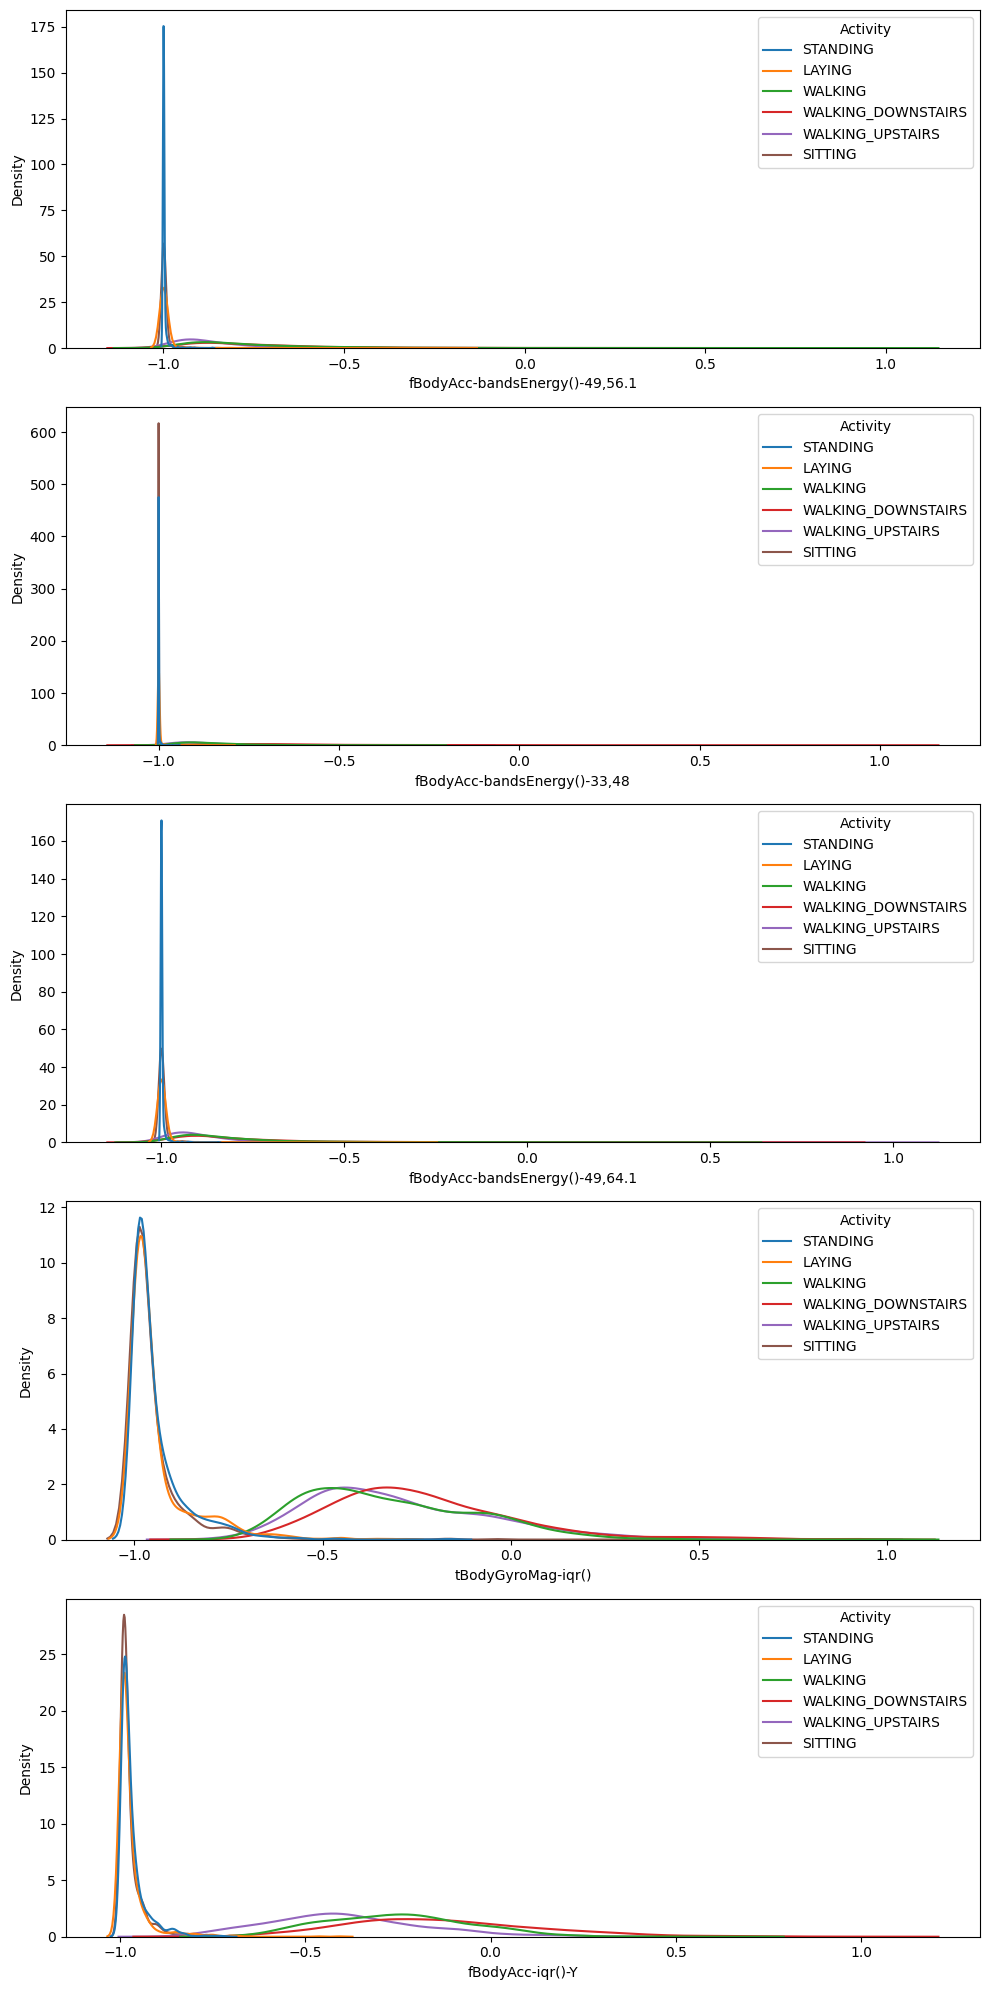

In [21]:
plt.figure(figsize=(10, len(asc_list)*4))
for idx in range(len(asc_list)):
  plt.subplot(5, 1, idx+1)
  # sns.histplot(data, x='tGravityAcc-mean()-X', hue=target, kde=True)
  sns.kdeplot(data, x=asc_list[idx][0], hue=target, common_norm=False)
plt.tight_layout()
plt.show()

## 4.미션2 : 데이터 분석2



다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [22]:
data2 = data.copy()
data2['is_dynamic'] = data2['Activity'].apply(lambda x : 1 if x in ('WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS') else 0)
target2 = 'is_dynamic'
x2 = data2.drop(columns=[target2, 'Activity'])
y2 = data2.loc[:, target2]
x_train2, x_val2, y_train2, y_val2 = train_test_split (x2, y2, test_size=0.3, random_state=20)

#### 2) 기본모델 생성

In [23]:
model2 = RandomForestClassifier()
model2.fit(x_train2, y_train2)

RandomForestClassifier()

In [24]:
y_pred2 = model2.predict(x_val2)

print(confusion_matrix(y_val2, y_pred2))
print(classification_report(y_val2, y_pred2))

[[956   0]
 [  0 809]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       956
           1       1.00      1.00      1.00       809

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



#### 3) 변수중요도 상위 5개 분석

In [25]:
fy2 = model2.feature_names_in_
fx2 = model2.feature_importances_

sort_dict2 = {}
for i in range(len(fy2)):
  sort_dict2[fy2[i]] = fx2[i]

sort_dict2 = sorted(sort_dict2.items(), key=lambda x: x[1])

asc_list2 = sort_dict2[:5]
desc_list2 = sort_dict2[-5:]

for temp in asc_list2:
  print(f'{temp[0]} : {temp[1]:.15f}')

print()

for temp in desc_list2:
  print(f'{temp[0]} : {temp[1]:.10f}')

tBodyAcc-std()-Y : 0.000000000000000
tBodyAcc-std()-Z : 0.000000000000000
tBodyAcc-mad()-Y : 0.000000000000000
tBodyAcc-mad()-Z : 0.000000000000000
tBodyAcc-max()-Y : 0.000000000000000

fBodyAccJerk-mad()-X : 0.0398132131
tBodyAccJerk-iqr()-Y : 0.0398626178
fBodyAccJerk-bandsEnergy()-1,8 : 0.0401532127
fBodyAccJerk-entropy()-X : 0.0598721773
fBodyAccJerk-bandsEnergy()-1,16 : 0.0599792035


                            feature_cate       max
20                      tBodyGyroJerkMag  0.000000
3   angle(tBodyAccJerkMean),gravityMean)  0.000000
4            angle(tBodyAccMean,gravity)  0.000000
5   angle(tBodyGyroJerkMean,gravityMean)  0.000000
6       angle(tBodyGyroMean,gravityMean)  0.000000
23                        tGravityAccMag  0.000010
12                      fBodyBodyGyroMag  0.000017
21                          tBodyGyroMag  0.000020
9                            fBodyAccMag  0.000029
17                           tBodyAccMag  0.000030
11                  fBodyBodyGyroJerkMag  0.000039
0                   angle(X,gravityMean)  0.000049
2                   angle(Z,gravityMean)  0.000058
1                   angle(Y,gravityMean)  0.000098
14                              tBodyAcc  0.000146
22                           tGravityAcc  0.000176
10                   fBodyBodyAccJerkMag  0.009824
13                             fBodyGyro  0.009971
18                             

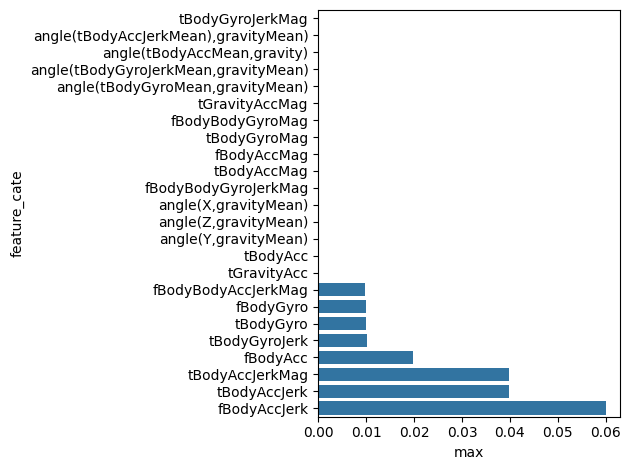

In [26]:
result = plot_feature_importance(model2.feature_importances_, model2.feature_names_in_, result_only=True, topn='all')

result['feature_cate'] = result['feature_name'].apply(lambda x : x.split('-')[0])

result = result.groupby(by='feature_cate')['feature_importance'].agg(['max'])
result = result.reset_index()
result = result.sort_values(by='max')

print(result)

sns.barplot(y=result['feature_cate'], x=result['max'])
# plt.axvline(data[target].value_counts().mean(), color='red', linestyle='--')
plt.tight_layout()
plt.show()

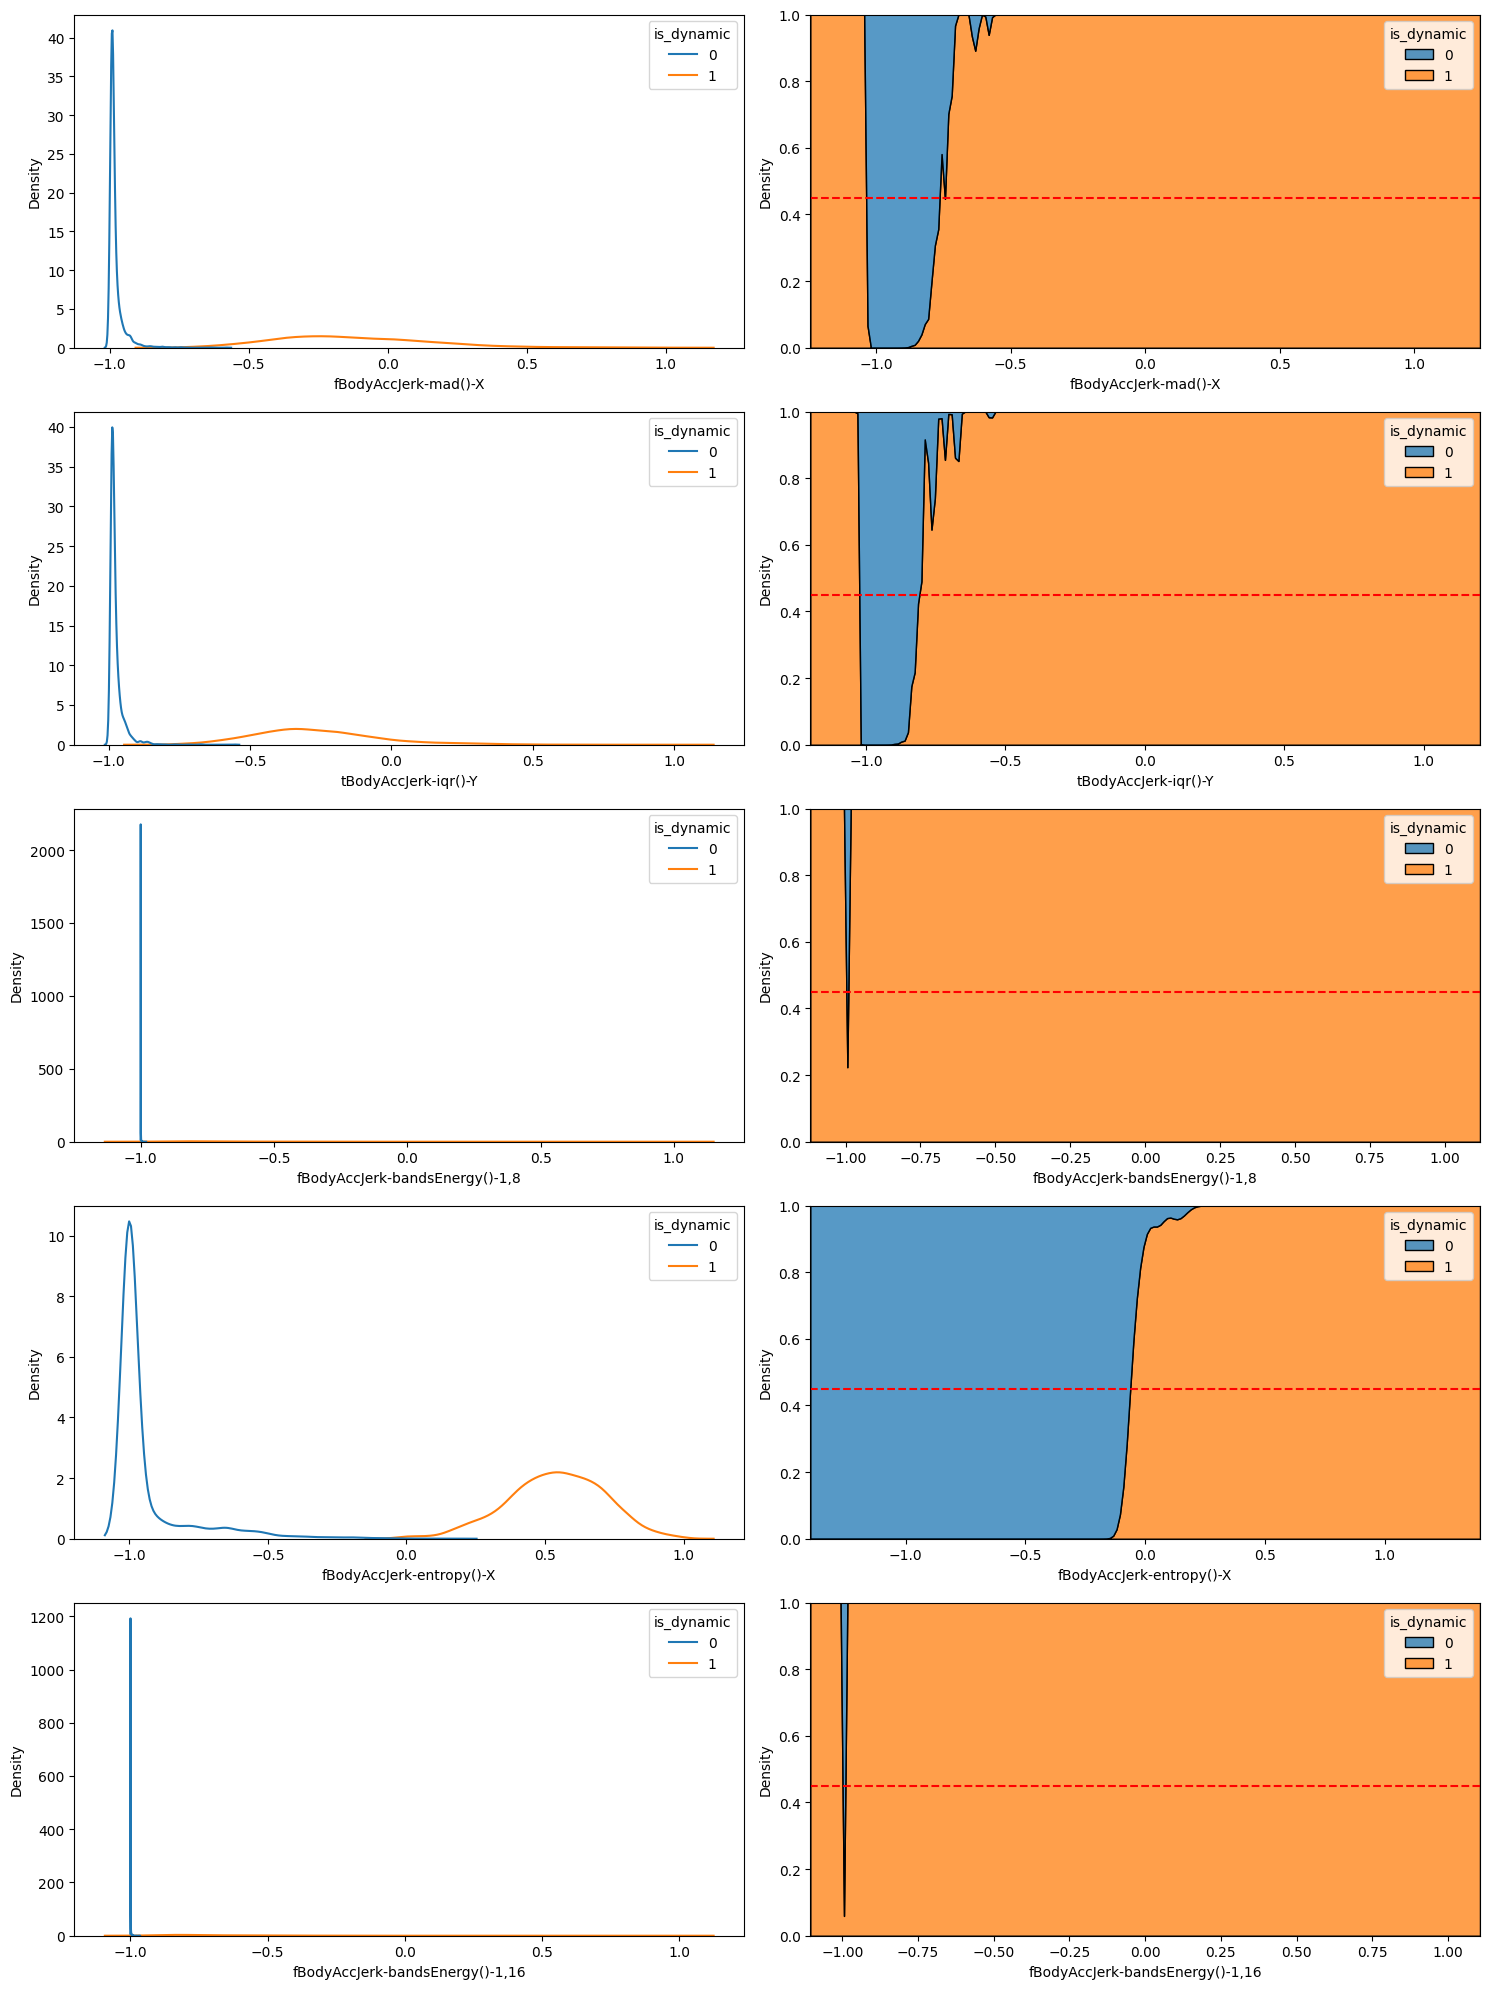

In [27]:
plt.figure(figsize=(15, len(desc_list2)*4))
for idx in range(len(desc_list2)):
  plt.subplot(len(desc_list2), 2, idx*2+1)
  # sns.histplot(data2, x=desc_list2[idx][0], hue=target2, common_norm=False, kde=True)
  sns.kdeplot(data2, x=desc_list2[idx][0], hue=target2, common_norm=False)

  plt.subplot(len(desc_list2), 2, idx*2+2)
  sns.kdeplot(data2, x=desc_list2[idx][0], hue=target2, multiple='fill')
  plt.axhline(data2['is_dynamic'].mean(), color='red', linestyle='--')
plt.tight_layout()
plt.show()

## 5. 추가 분석

센서 그룹별로 Feature 를 분류하여, 세부 센서 중요도 추출


높은 중요도를 보이는 특정 센서에 대해, 각 세부 조사를 위해 작성됨

In [33]:
# 센서 그룹별로 feature 분류
sensor_groups = {
    'tBodyAcc': [col for col in data.columns if 'tBodyAcc' in col and 'Mag' not in col],
    'tGravityAcc': [col for col in data.columns if 'tGravityAcc' in col and 'Mag' not in col],
    'tBodyAccJerk': [col for col in data.columns if 'tBodyAccJerk' in col and 'Mag' not in col],
    'tBodyGyro': [col for col in data.columns if 'tBodyGyro' in col and 'Mag' not in col],
    'tBodyGyroJerk': [col for col in data.columns if 'tBodyGyroJerk' in col and 'Mag' not in col],
    'tBodyAccMag': [col for col in data.columns if 'tBodyAccMag' in col],
    'tGravityAccMag': [col for col in data.columns if 'tGravityAccMag' in col],
    'tBodyAccJerkMag': [col for col in data.columns if 'tBodyAccJerkMag' in col],
    'tBodyGyroMag': [col for col in data.columns if 'tBodyGyroMag' in col],
    'tBodyGyroJerkMag': [col for col in data.columns if 'tBodyGyroJerkMag' in col],
    'fBodyAcc': [col for col in data.columns if 'fBodyAcc' in col and 'Mag' not in col],
    'fBodyAccJerk': [col for col in data.columns if 'fBodyAccJerk' in col and 'Mag' not in col],
    'fBodyGyro': [col for col in data.columns if 'fBodyGyro' in col and 'Mag' not in col],
    'fBodyAccMag': [col for col in data.columns if 'fBodyAccMag' in col],
    'fBodyBodyAccJerkMag': [col for col in data.columns if 'fBodyBodyAccJerkMag' in col],
    'fBodyBodyGyroMag': [col for col in data.columns if 'fBodyBodyGyroMag' in col],
    'fBodyBodyGyroJerkMag': [col for col in data.columns if 'fBodyBodyGyroJerkMag' in col],
    'angle': [col for col in data.columns if 'angle' in col]
}
def train_rf_with_features(features, X, y):
    X_selected = X[features]
    X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    })

    return importance.sort_values(by='Importance', ascending=False)

data3 = data.copy()
data3['is_dynamic'] = data3['Activity'].apply(lambda x : 1 if x in ('WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS') else 0)
x3 = data3.drop(columns=['is_dynamic', 'Activity'])
y3 = data3['is_dynamic']

important_features = {}
for sensor, features in sensor_groups.items():
    importance_df = train_rf_with_features(features, x3, y3)
    important_features[sensor] = importance_df

for sensor, importance_df in important_features.items():
    print(f"센서: {sensor}")
    display(importance_df.head())
    print('='*80)

센서: tBodyAcc


,Feature,Importance
46,tBodyAccJerk-mad()-X,0.160201
62,tBodyAccJerk-entropy()-X,0.100226
43,tBodyAccJerk-std()-X,0.090055
59,tBodyAccJerk-iqr()-X,0.080198
60,tBodyAccJerk-iqr()-Y,0.069548


센서: tGravityAcc


,Feature,Importance
3,tGravityAcc-std()-X,0.125797
6,tGravityAcc-mad()-X,0.087693
1,tGravityAcc-mean()-Y,0.084763
19,tGravityAcc-iqr()-X,0.079882
13,tGravityAcc-min()-Y,0.073385


센서: tBodyAccJerk


,Feature,Importance
16,tBodyAccJerk-energy()-X,0.130213
6,tBodyAccJerk-mad()-X,0.130169
19,tBodyAccJerk-iqr()-X,0.110055
22,tBodyAccJerk-entropy()-X,0.109830
20,tBodyAccJerk-iqr()-Y,0.109538


센서: tBodyGyro


,Feature,Importance
55,tBodyGyroJerk-sma(),0.100148
61,tBodyGyroJerk-iqr()-Z,0.090848
64,tBodyGyroJerk-entropy()-Z,0.089570
59,tBodyGyroJerk-iqr()-X,0.079952
48,tBodyGyroJerk-mad()-Z,0.070034


센서: tBodyGyroJerk


,Feature,Importance
8,tBodyGyroJerk-mad()-Z,0.170112
15,tBodyGyroJerk-sma(),0.160387
21,tBodyGyroJerk-iqr()-Z,0.128421
24,tBodyGyroJerk-entropy()-Z,0.080366
19,tBodyGyroJerk-iqr()-X,0.080203


센서: tBodyAccMag


,Feature,Importance
8,tBodyAccMag-entropy(),0.234249
5,tBodyAccMag-sma(),0.144183
0,tBodyAccMag-mean(),0.140907
6,tBodyAccMag-energy(),0.122852
3,tBodyAccMag-max(),0.109881


센서: tGravityAccMag


,Feature,Importance
0,tGravityAccMag-mean(),0.219140
5,tGravityAccMag-sma(),0.215288
8,tGravityAccMag-entropy(),0.190972
1,tGravityAccMag-std(),0.095606
6,tGravityAccMag-energy(),0.094703


센서: tBodyAccJerkMag


,Feature,Importance
0,tBodyAccJerkMag-mean(),0.249631
5,tBodyAccJerkMag-sma(),0.160604
6,tBodyAccJerkMag-energy(),0.159761
8,tBodyAccJerkMag-entropy(),0.143743
7,tBodyAccJerkMag-iqr(),0.109462


센서: tBodyGyroMag


,Feature,Importance
5,tBodyGyroMag-sma(),0.233095
6,tBodyGyroMag-energy(),0.214208
0,tBodyGyroMag-mean(),0.192495
2,tBodyGyroMag-mad(),0.106417
3,tBodyGyroMag-max(),0.094391


센서: tBodyGyroJerkMag


,Feature,Importance
0,tBodyGyroJerkMag-mean(),0.318787
5,tBodyGyroJerkMag-sma(),0.180360
8,tBodyGyroJerkMag-entropy(),0.128596
7,tBodyGyroJerkMag-iqr(),0.109418
6,tBodyGyroJerkMag-energy(),0.099626


센서: fBodyAcc


,Feature,Importance
116,"fBodyAccJerk-bandsEnergy()-1,8",0.110161
101,fBodyAccJerk-entropy()-X,0.089853
124,"fBodyAccJerk-bandsEnergy()-1,16",0.060316
82,fBodyAccJerk-std()-X,0.059839
128,"fBodyAccJerk-bandsEnergy()-1,24",0.050217


센서: fBodyAccJerk


,Feature,Importance
9,fBodyAccJerk-max()-X,0.110513
3,fBodyAccJerk-std()-X,0.090154
22,fBodyAccJerk-entropy()-X,0.089733
6,fBodyAccJerk-mad()-X,0.089564
49,"fBodyAccJerk-bandsEnergy()-1,24",0.070216


센서: fBodyGyro


,Feature,Importance
15,fBodyGyro-sma(),0.100210
1,fBodyGyro-mean()-Y,0.089650
7,fBodyGyro-mad()-Y,0.089099
24,fBodyGyro-entropy()-Z,0.078882
63,"fBodyGyro-bandsEnergy()-1,24.1",0.059751


센서: fBodyAccMag


,Feature,Importance
7,fBodyAccMag-iqr(),0.219845
8,fBodyAccMag-entropy(),0.203366
0,fBodyAccMag-mean(),0.135423
5,fBodyAccMag-sma(),0.130089
2,fBodyAccMag-mad(),0.104237


센서: fBodyBodyAccJerkMag


,Feature,Importance
7,fBodyBodyAccJerkMag-iqr(),0.240680
0,fBodyBodyAccJerkMag-mean(),0.188313
5,fBodyBodyAccJerkMag-sma(),0.168945
8,fBodyBodyAccJerkMag-entropy(),0.168934
2,fBodyBodyAccJerkMag-mad(),0.089757


센서: fBodyBodyGyroMag


,Feature,Importance
8,fBodyBodyGyroMag-entropy(),0.266503
0,fBodyBodyGyroMag-mean(),0.207792
5,fBodyBodyGyroMag-sma(),0.152783
7,fBodyBodyGyroMag-iqr(),0.132705
6,fBodyBodyGyroMag-energy(),0.088207


센서: fBodyBodyGyroJerkMag


,Feature,Importance
7,fBodyBodyGyroJerkMag-iqr(),0.197765
8,fBodyBodyGyroJerkMag-entropy(),0.167881
0,fBodyBodyGyroJerkMag-mean(),0.138733
5,fBodyBodyGyroJerkMag-sma(),0.119456
2,fBodyBodyGyroJerkMag-mad(),0.117407


센서: angle


,Feature,Importance
5,"angle(Y,gravityMean)",0.255126
0,"angle(tBodyAccMean,gravity)",0.207180
2,"angle(tBodyGyroMean,gravityMean)",0.176562
1,"angle(tBodyAccJerkMean),gravityMean)",0.118381
6,"angle(Z,gravityMean)",0.116371


## 6. 결론

데이터에 feature가 많은 상태여서 다음과 같은 전처리가 필요할 것으로 예측
- Feature를 축소 필요
- 이상치를 탐색하여 제거 필요

# 1. Activity
STANDING, STIING 간의 분류 정확도가 조금 부족한 상황(사전 조사를 진행하여 결과 확인)

두 분류에 대해 중요한 Feature를 도출하여 정확도 상승에 대해 집중 필요

# 2. is_dynamic
Accuracy score가 1.0이 나오는 상황

Feature를 줄이는 것 외 추가 전처리는 중요도가 낮음